# <a id='toc1_'></a>[MNIST image completion with ACE](#toc0_)




**Table of contents**<a id='toc0_'></a>    
- [MNIST image completion with ACE](#toc1_)    
  - [Notebook description](#toc1_1_)    
  - [Imports](#toc1_2_)    
  - [Preparation](#toc1_3_)    
    - [Load the trained model and config](#toc1_3_1_)    
    - [Number of context points and the index of the image to plot](#toc1_3_2_)    
    - [Functions to build batch and generate images](#toc1_3_3_)    
  - [Running ACE on MNIST image completion task](#toc1_4_)    
    - [Generate data for a batch](#toc1_4_1_)    
    - [Build batch both with and without latents](#toc1_4_2_)    
    - [Plot the predictions for both cases](#toc1_4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Notebook description](#toc0_)

In this notebook, we will demonstrate the capabilities of the Amortized Conditioning Engine (ACE) for image completion tasks on the MNIST dataset. The task is to generate the rest of an image given some context points. Since ACE can condition on latent variables (in this case, the class label), we will compare the following two cases:
1. No class conditioning
2. With class conditioning

## <a id='toc1_2_'></a>[Imports](#toc0_)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import torch
import copy
from src.model.utils import AttrDict
from src.dataset.latents.image_no_np import Image
import matplotlib.pyplot as plt
from bo_demo_utils import load_config_and_model
import warnings
warnings.filterwarnings('ignore')

# Load the trained model and config
path = "model/mnist/"
config_path = path+".hydra/"


## <a id='toc1_3_'></a>[Preparation](#toc0_)

### <a id='toc1_3_1_'></a>[Load the trained model and config](#toc0_)

In [2]:

torch.manual_seed(45)

# Load ACE model and config
cfg, model = load_config_and_model(path, path + ".hydra/", 
                                   ckpt_name="ckpt_140000.tar")

### <a id='toc1_3_2_'></a>[Number of context points and the index of the image to plot](#toc0_)

In [3]:
ind = 7
num_ctx = 10

### <a id='toc1_3_3_'></a>[Functions to build batch and generate images](#toc0_)

In this notebook, we define two functions we need to do the image completion task.

The first function, `build_batch`, takes data points `b_xyd`, latents `b_xyl`, and the number of context points `num_ctx` as inputs. It returns two context-target sets: one without latents and the other with latents, both containing the specified `num_ctx`.

The second function, `generate_image`, is our main function. Given a pair of context-target sets, it predicts the target points (pixels to fill) and visualizes the results.

In [4]:
def build_batch(b_xyd, b_xyl, num_ctx):
    """
    Construct batches for context and target points from input data and latents.

    Parameters:
    -----------
    b_xyd : torch.Tensor
        Batch of input data containing x, y coordinates and density values.
        Shape: [batch_size, num_points, 4]
    b_xyl : torch.Tensor
        Batch of latent representations.
        Shape: [batch_size, num_latent_points, 4]
    num_ctx : int
        Number of context points to use from the input data.

    Returns:
    --------
    batch : AttrDict
        Batch dictionary containing context and target points without latents.
    batch_l : AttrDict
        Batch dictionary containing context and target points with latents.
    """

    xyc = b_xyd[:, :num_ctx, :]
    xyt = b_xyd[:, num_ctx:, :] 

    batch = AttrDict() 
    batch.xc = copy.deepcopy(xyc[:, :, :-1])
    batch.yc = copy.deepcopy(xyc[:, :, -1:])

    batch.xt = copy.deepcopy(xyt[:, :, :-1])
    batch.yt = copy.deepcopy(xyt[:, :, -1:])

    xyc_latent = torch.concat((xyc, b_xyl), dim=1)

    batch_l = AttrDict({
        'xc': xyc_latent[:, :, :-1],
        'yc': xyc_latent[:, :, -1:],
        'xt': xyt[:, :, :-1],
        'yt': xyt[:, :, -1:]
    })
    return batch, batch_l

def generate_image(batch, batch_l, ind):
    """
    Visualize images based on context points and latents.

    Parameters:
    -----------
    b_xyd : torch.Tensor
        Batch of input data containing x, y coordinates and density values.
        Shape: [batch_size, num_points, 4]
    b_xyl : torch.Tensor
        Batch of latent representations.
        Shape: [batch_size, num_latent_points, 4]
    ind : int
        Index of the specific image in the batch to visualize.
    num_ctx : int
        Number of context points to use from the input data.

    Returns:
    --------
    None
    """
        

    # First image
    xc = (15 * batch.xc[ind, :, 1:3]).to(torch.long)
    yc = batch.yc[ind, :, -1]
    image_size = 16

    im_context = np.zeros((image_size, image_size, 3))
    im_context[:, :, 2] = 1
    im_context[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1).cpu()

    # Second image
    xc = (15 * batch.xt[ind, :, 1:3]).to(torch.long)
    yc = batch.yt[ind, :, -1]
    im_target = np.zeros((image_size, image_size, 3))
    im_target[:, :, 2] = 1
    im_target[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1).cpu()

    out = model.forward(batch, predict=True)
    xc = (15 * batch.xt[ind,:, 1:3]).to(torch.long)
    yc = out.median[ind, :]
    image_size = 16

    im_nl = np.zeros((image_size, image_size, 3))
    im_nl[:, :, 2] = 1
    im_nl[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1)

    out = model.forward(batch_l, predict=True)
    xc = (15 * batch.xt[ind,:, 1:3]).to(torch.long)
    yc = out.median[ind, :]
    image_size = 16

    im_l = np.zeros((image_size, image_size, 3))
    im_l[:, :, 2] = 1
    im_l[xc[:, 0], xc[:, 1]] = yc.repeat(3, 1).transpose(0, 1)

    # Plotting the images next to each other
    fig, axs = plt.subplots(1, 4, figsize=(10, 5))

    axs[0].imshow(im_context)
    axs[0].axis('off')  # Remove axis labels
    axs[0].set_title('Context Image')

    axs[1].imshow(im_target)
    axs[1].axis('off')  # Remove axis labels
    axs[1].set_title('Target Image')

    axs[2].imshow(im_nl)
    axs[2].axis('off')  # Remove axis labels
    axs[2].set_title('ACE no class conditioning')

    axs[3].imshow(im_l)
    axs[3].axis('off')  # Remove axis labels
    axs[3].set_title('ACE with class conditioning')

    plt.tight_layout()
    plt.show()

## <a id='toc1_4_'></a>[Running ACE on MNIST image completion task](#toc0_)

### <a id='toc1_4_1_'></a>[Generate data for a batch](#toc0_)


Here, we generate data points `b_xyd`(pixels, in this case) and latents `b_xyl` (MNIST labels).

In [5]:
torch.manual_seed(45)

image = Image()
b_xyd, b_xyl = image.get_data() 

### <a id='toc1_4_2_'></a>[Build batch both with and without latents](#toc0_)

Next, we build the context-target sets for both cases: one with latents (`batch_l`) and one without latents (`batch`).

In [6]:
batch, batch_l = build_batch(b_xyd, b_xyl, num_ctx)

### <a id='toc1_4_3_'></a>[Plot the predictions for both cases](#toc0_)

Finally, we run the ACE prediction both without class conditioning and with class conditioning. Notice that the ACE prediction with conditioning provides a better result, even with a small number of context points, compared to the prediction without class conditioning.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004250747617334127..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004930212162435055..1.0].


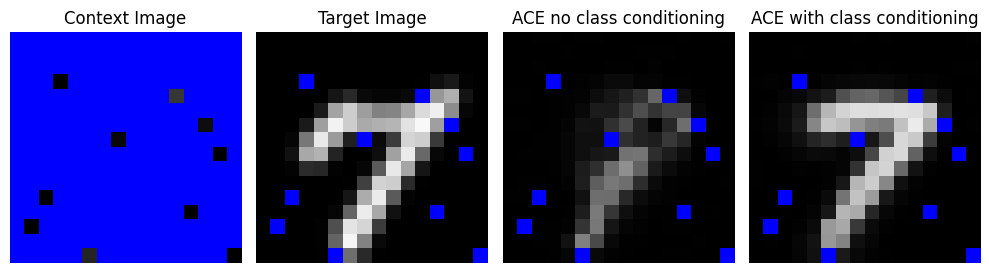

In [7]:
generate_image(batch, batch_l, ind)